# Credit Card Fraud Detection Using Machine Learning

## Project Overview
This notebook implements a comprehensive credit card fraud detection system using machine learning techniques. The project addresses the challenge of identifying fraudulent transactions in highly imbalanced datasets.

## Key Features
- **Data Preprocessing**: Handles duplicates, outliers, and missing values
- **Feature Engineering**: Standardization and scaling of transaction amounts
- **Class Imbalance Handling**: Uses SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset
- **Machine Learning Model**: Random Forest Classifier with optimized hyperparameters
- **Comprehensive Analysis**: Includes exploratory data analysis (EDA), correlation analysis, and feature importance visualization

## Dataset
The dataset contains credit card transactions with 30 features (V1-V28 are PCA-transformed for privacy, plus Time, Amount, and Class label).

## Workflow
1. Load and explore the dataset
2. Clean data (remove duplicates and handle outliers)
3. Perform exploratory data analysis
4. Feature scaling and preprocessing
5. Split data into training and testing sets
6. Apply SMOTE to handle class imbalance
7. Train Random Forest model
8. Evaluate model performance
9. Save trained model for deployment

## Step 0: Import Required Libraries
Import essential libraries for data manipulation, visualization, and modeling.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [16]:
# 1) Load Dataset
# ---------------------------
data = pd.read_csv("creditcard.csv")
print("Dataset Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (284807, 31)

Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [17]:
# 2) Remove Duplicate Rows
# ---------------------------
duplicates = data.duplicated().sum()
print("\nNumber of Duplicates:", duplicates)

if duplicates > 0:
    data = data.drop_duplicates()
    print("New Shape After Removing Duplicates:", data.shape)


Number of Duplicates: 1081
New Shape After Removing Duplicates: (283726, 31)


In [18]:
# 3) Statistical Summary
# ---------------------------
print("\nStatistical Summary:")
print(data.describe())


Statistical Summary:
                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        

In [19]:
# 4) Detect Outliers in Amount (IQR Method)
# ---------------------------
Q1 = data["Amount"].quantile(0.25)
Q3 = data["Amount"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = data[(data["Amount"] < lower) | (data["Amount"] > upper)]
print("\nOutliers in Amount:", len(outliers))
print("Percentage of Outliers: {:.4f}%".format(len(outliers)/len(data)*100))


Outliers in Amount: 31685
Percentage of Outliers: 11.1675%


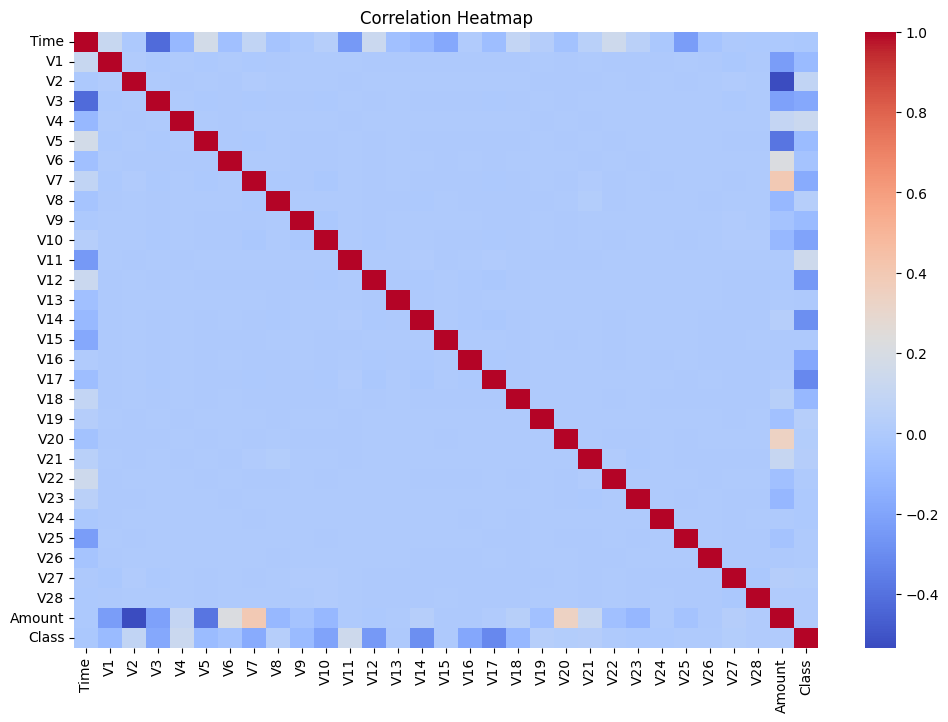

In [20]:
# 5) Correlation Heatmap
# ---------------------------
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# 6) Feature Scaling (Amount)
# ---------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data["Scaled_Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

# Drop Time column for modeling readiness
model_data = data.drop(["Time", "Amount"], axis=1)

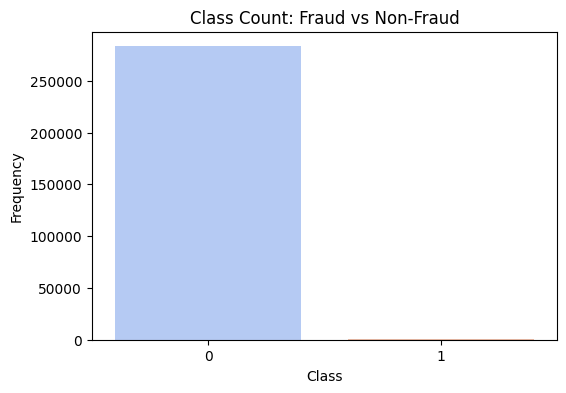

In [19]:
# 7) Class Distribution Visualization
# ---------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=model_data, palette="coolwarm")
plt.title("Class Count: Fraud vs Non-Fraud")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [22]:
# Show percentage of each class
class_counts = model_data["Class"].value_counts()
print("\nClass Distribution:")
print(class_counts)
print("\nClass Percentages:")
print(round(class_counts / len(model_data) * 100, 2))


Class Distribution:
Class
0    283253
1       473
Name: count, dtype: int64

Class Percentages:
Class
0    99.83
1     0.17
Name: count, dtype: float64


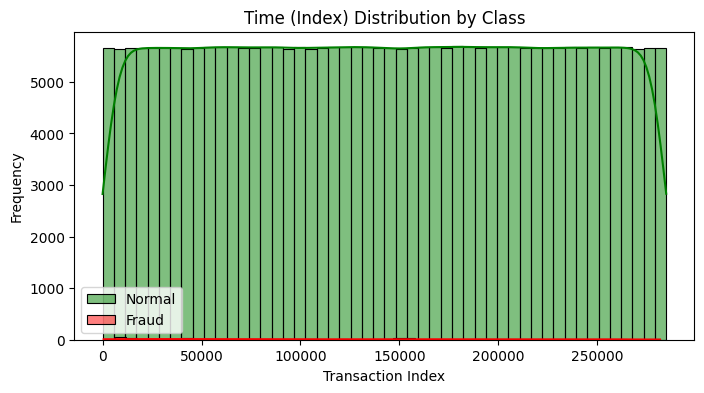

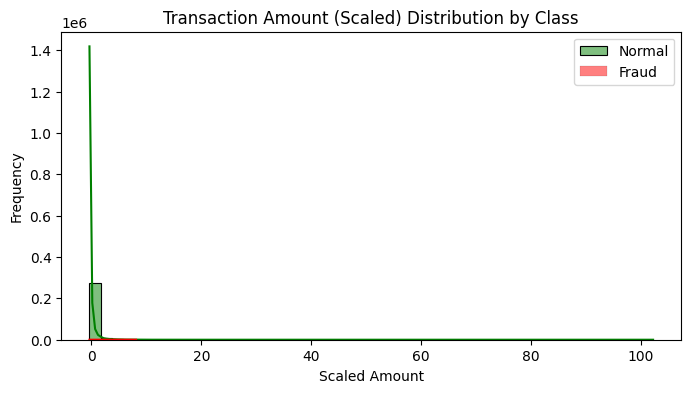

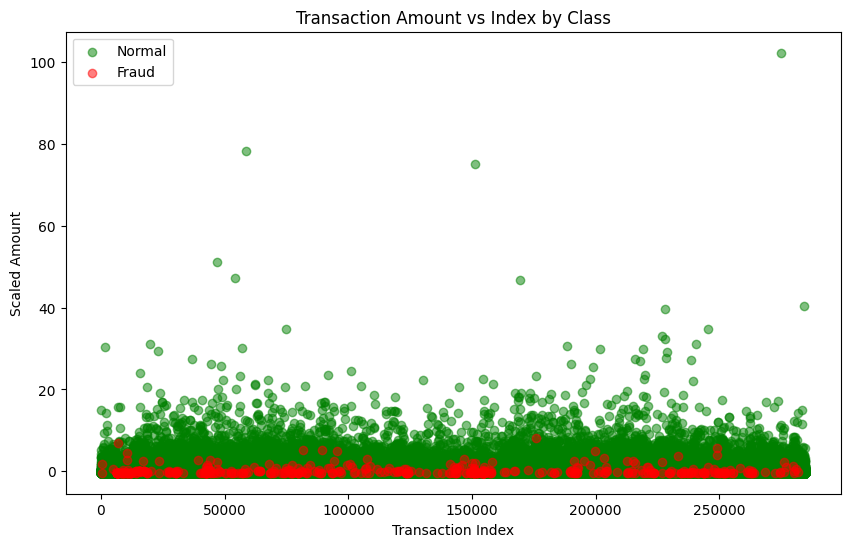

In [21]:
# 8) Distribution of Time and Amount by Class
# ---------------------------
fraud = model_data[model_data.Class == 1]
normal = model_data[model_data.Class == 0]

# Time Distribution (Index as proxy)
plt.figure(figsize=(8,4))
sns.histplot(normal.index, color='g', label='Normal', bins=50, kde=True)
sns.histplot(fraud.index, color='r', label='Fraud', bins=50, kde=True)
plt.title("Time (Index) Distribution by Class")
plt.xlabel("Transaction Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Amount Distribution
plt.figure(figsize=(8,4))
sns.histplot(normal.Scaled_Amount, color='g', label='Normal', bins=50, kde=True)
sns.histplot(fraud.Scaled_Amount, color='r', label='Fraud', bins=50, kde=True)
plt.title("Transaction Amount (Scaled) Distribution by Class")
plt.xlabel("Scaled Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Scatter Plot of Amount vs Time (Index)
plt.figure(figsize=(10,6))
plt.scatter(normal.index, normal.Scaled_Amount, c='g', label='Normal', alpha=0.5)
plt.scatter(fraud.index, fraud.Scaled_Amount, c='r', label='Fraud', alpha=0.5)
plt.title("Transaction Amount vs Index by Class")
plt.xlabel("Transaction Index")
plt.ylabel("Scaled Amount")
plt.legend()
plt.show()

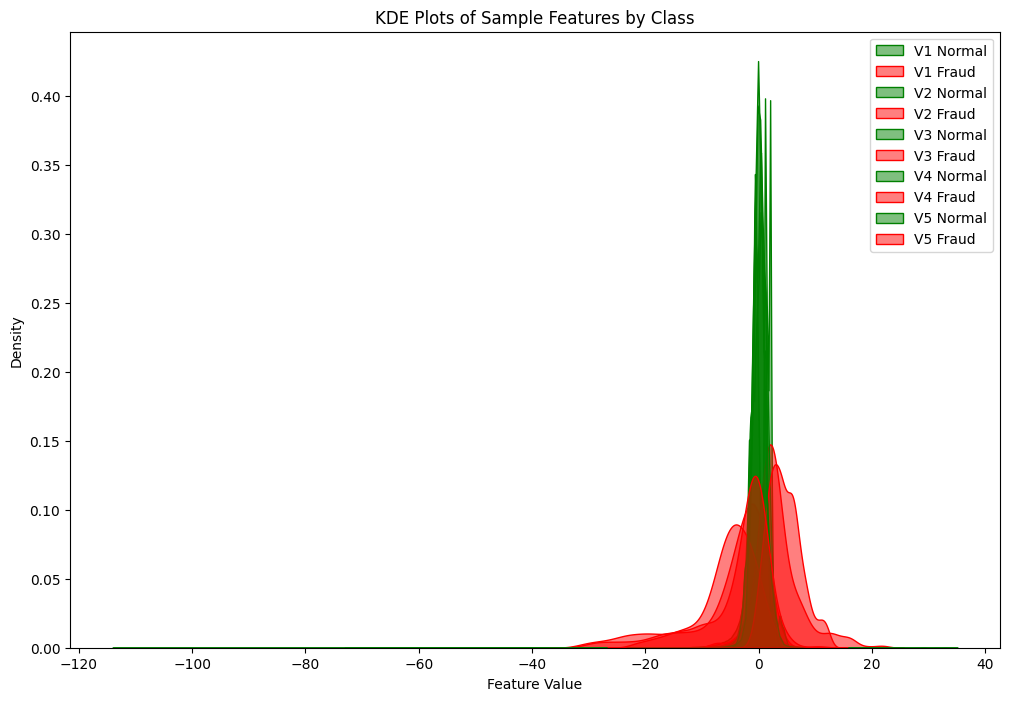

In [25]:
# 9) KDE Plots for Sample Features (V1-V5 for brevity)
# ---------------------------
sample_features = ['V1','V2','V3','V4','V5']
plt.figure(figsize=(12,8))
for feature in sample_features:
    sns.kdeplot(normal[feature], label=f'{feature} Normal', shade=True, alpha=0.5, color='g')
    sns.kdeplot(fraud[feature], label=f'{feature} Fraud', shade=True, alpha=0.5, color='r')
plt.title("KDE Plots of Sample Features by Class")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()

## Train-Test Split
Split the dataset into training and testing sets with stratification to maintain class distribution.

In [26]:
from sklearn.model_selection import train_test_split

features = [c for c in data.columns if c.startswith('V')] + ['Scaled_Amount']

X = data[features]
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (226980, 29) Test: (56746, 29)


## Apply SMOTE (Handling Class Imbalance)
Use SMOTE to generate synthetic samples of the minority class (fraud) to balance the training data.

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    226602
1       378
Name: count, dtype: int64
After SMOTE: Class
0    226602
1    226602
Name: count, dtype: int64


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)


,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.78      0.80        95

    accuracy                           1.00     56746
   macro avg       0.91      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
[[56634    17]
 [   21    74]]
ROC-AUC: 0.96774043102319


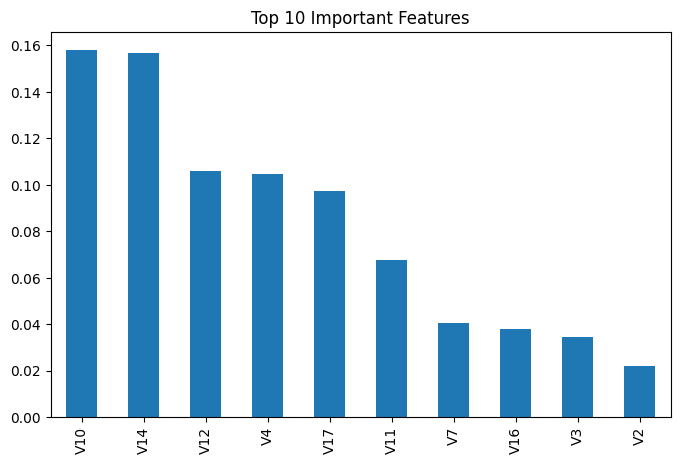

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=features)
top = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top.plot(kind='bar')
plt.title("Top 10 Important Features")
plt.show()


In [31]:
import joblib

joblib.dump(rf, "random_forest_fraud.pkl")
print("Model saved!")


Model saved!
